In [1]:
using NeuroPALData, PyPlot, YAML, ANTSUNData, Statistics, DelimitedFiles,
    ProgressMeter, HDF5, FlavellBase, ConnectomePlot, JLD2

WebIO._IJuliaInit()

In [2]:
path_fig_root = "/data1/prj_kfc/figure/manuscript/cell_draft2/figure4/"

"/data1/prj_kfc/figure/manuscript/cell_draft2/figure4/"

In [3]:
θh_pos_is_ventral = YAML.load_file("/data1/prj_kfc/data/data_constant/pos_is_ventral.yaml");

## Data

### Load data

In [4]:
list_uid_baseline = sort(["2022-06-14-01", "2022-06-14-07",
    "2022-06-14-13", "2022-06-28-01", "2022-06-28-07",
    "2022-07-15-06", "2022-07-15-12",
    "2022-07-20-01", "2022-07-26-01", "2022-08-02-01",
    "2023-01-09-28", "2023-01-17-01", "2023-01-19-01",
    "2023-01-19-08", "2023-01-19-15", "2023-01-19-22",
    "2023-01-23-01", "2023-01-23-08", "2023-01-23-15", "2023-01-23-21",
    "2023-03-07-01"])

list_uid_heat = ["2022-12-21-06", "2023-01-05-01", "2023-01-05-18",
    "2023-01-06-01", "2023-01-06-08", "2023-01-06-15", "2023-01-09-08",
    "2023-01-09-15", "2023-01-09-22", "2023-01-10-07", "2023-01-10-14",
    "2023-01-13-07", "2023-01-16-01", "2023-01-16-08", "2023-01-16-15",
    "2023-01-16-22", "2023-01-17-07", "2023-01-17-14", "2023-01-18-01"] |> sort;
# short: "2022-05-17-01", "2022-05-17-06"

In [5]:
list_uid = vcat(list_uid_baseline, list_uid_heat);

In [6]:
list_data_dict = []
@showprogress for (idx_uid, data_uid) = enumerate(list_uid)
    path_data = "/scratch/prj_kfc/processed_h5/$(data_uid)-data.h5"
    data_dict = import_data(path_data, custom_keys=["neuropal_registration"])

    push!(list_data_dict, data_dict)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


### Load NeuroPAL

In [7]:
list_neuropal_label = load("/scratch/prj_kfc/list_neuropal_label.jld2")["list_neuropal_label"];

In [8]:
# path_h5_enc = "/data1/prj_kfc/data/gen_analysis_data/2022-10-14-neuropal-enc.h5"
path_h5_enc = "/scratch/prj_kfc/2023-03-31-neuropal-baseline-enc.h5"
path_h5_enc_heat = "/scratch/prj_kfc/2023-03-07-neuropal-heatstim-enc.h5"
list_dict_fit = []

@showprogress for uid = list_uid
    if uid in list_uid_baseline
        push!(list_dict_fit, h5read(path_h5_enc, uid))
    elseif uid in list_uid_heat
        push!(list_dict_fit, h5read(path_h5_enc_heat, uid))        
    else
        error("$uid does not exist")
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:01:18


In [9]:
list_neuropal_order_info = readdlm("/data1/prj_neuropal/data/neuropal_label_prj_kfc/NeuroPAL order LR.csv",',');

In [10]:
list_class_dv = get_list_class_dv(map(x->x[1],list_neuropal_label));

In [11]:
list_class_ordered = generate_list_class_custom_order(list_neuropal_order_info, list_class_dv);

┌ Warning: class ASE is not in the orderling file
└ @ NeuroPALData ~/.julia/packages/NeuroPALData/P9Wwv/src/class.jl:100
┌ Warning: class IL1 is not in the orderling file
└ @ NeuroPALData ~/.julia/packages/NeuroPALData/P9Wwv/src/class.jl:100
┌ Warning: class IL2 is not in the orderling file
└ @ NeuroPALData ~/.julia/packages/NeuroPALData/P9Wwv/src/class.jl:100
┌ Warning: class RMH is not in the orderling file
└ @ NeuroPALData ~/.julia/packages/NeuroPALData/P9Wwv/src/class.jl:100
┌ Warning: class SAAD is not in the orderling file
└ @ NeuroPALData ~/.julia/packages/NeuroPALData/P9Wwv/src/class.jl:100
┌ Warning: class SABV is not in the orderling file
└ @ NeuroPALData ~/.julia/packages/NeuroPALData/P9Wwv/src/class.jl:100


In [12]:
list_class_classify_dv_enc = ["SIA", "SMB"] # classify based on D/V tuning

2-element Vector{String}:
 "SIA"
 "SMB"

In [13]:
list_match_dict = get_list_match_dict(list_neuropal_label, list_data_dict=list_data_dict, list_dict_fit=list_dict_fit,
    list_class_ordered=list_class_ordered, list_class_classify_dv_enc=list_class_classify_dv_enc,
    θ_confidence_label=2.5);

In [14]:
list_uid_no_pumping = h5read(path_h5_enc, "list_uid_invalid_pt")
list_uid_pumping = setdiff(list_uid, list_uid_no_pumping)
list_idx_uid_pumping = [idx_uid for idx_uid = 1:length(list_uid) if list_uid[idx_uid] in list_uid_pumping];

In [15]:
list_class_dv_ordered = let
    list_all_class = unique(vcat(map(x->collect(keys(x[2])), list_match_dict)...))
    list_intersect = intersect(map(x->x[2], list_class_ordered), list_all_class)
    println("missing (in the ordering file but not in the matches): ", setdiff(setdiff(map(x->x[2], list_class_ordered), list_all_class)))
    println("n(class): $(length(list_intersect))")
    list_intersect
end;

missing (in the ordering file but not in the matches): Any["AVG", "RIG", "DB02", "DD01", "VB01", "ADF"]
n(class): 97


## Table generation

In [16]:
function get_list_use_rg_t(list_uid, list_uid_heat, list_dict_fit; θ_pumping=0.5)
    list_all = Tuple{String,Vector{Int}}[]
    list_pumping = Tuple{String,Vector{Int}}[]
    
    for (i_uid, uid) = enumerate(list_uid)
        lattice_range_p = list_dict_fit[i_uid]["lattice_range"]["P"]
        
        q_heat = uid in list_uid_heat
        rg_t = q_heat ? Int[1] : 1:length(lattice_range_p)
        
        list_rg_t_all = Int[]
        list_rg_t_pumping = Int[]
        
        for i_rg_t = rg_t
            # check pumping variance
            lattice_p = lattice_range_p["$i_rg_t"]
            if abs(lattice_p[2] - lattice_p[1]) .> θ_pumping
                push!(list_rg_t_pumping, i_rg_t)
            end
            
            push!(list_rg_t_all, i_rg_t)
        end
        
        push!(list_all, (uid, list_rg_t_all))
        push!(list_pumping, (uid, list_rg_t_pumping))
    end
    
    list_all, list_pumping
end

list_uid_use_all, list_uid_use_pumping = get_list_use_rg_t(list_uid, list_uid_heat, list_dict_fit);

### Behavior categorization

In [20]:
const list_b_category = [
    ("v", "fwd", "fwd"), # 1
    ("v", "rev", "rev"), # 2
    ("v", "fwd_slope_pos", "fwd slope +"), # 3
    ("v", "fwd_slope_neg", "fwd slope -"), # 4
    ("v", "rev_slope_pos", "rev slope +"), # 5
    ("v", "rev_slope_neg", "rev slope -"), # 6
    ("v", "rect_pos", "rect +"), # 7
    ("v", "rect_neg", "rect -"), # 8

    
    ("θh", "dorsal", "dorsal"), # 9
    ("θh", "ventral", "ventral"), # 10
    ("θh", "fwd_dorsal", "fwd dorsal"), # 11
    ("θh", "fwd_ventral", "fwd ventral"), # 12
    ("θh", "rev_dorsal", "rev dorsal"), # 13
    ("θh", "rev_ventral", "rev ventral"), # 14
    ("θh", "rect_dorsal", "rect dorsal"), # 15
    ("θh", "rect_ventral", "rect ventral"), # 16
    
    ("P", "act", "+"), # 17
    ("P", "inh", "-"), # 18
    ("P", "fwd_act", "fwd +"), #19
    ("P", "fwd_inh", "fwd -"), # 
    ("P", "rev_act", "fwd +"), # 21
    ("P", "rev_inh", "fwd -"), #
    ("P", "rect_act", "rect +"), # 23
    ("P", "rect_inh", "rect -") # 24
];

In [21]:
list_rm_class_dv = ["M2"]

1-element Vector{String}:
 "M2"

In [22]:
let
    list_class_dv = setdiff(list_class_dv_ordered, list_rm_class_dv)
    
    n_class = length(list_class_dv)
    n_behavior_subcat = length(list_b_category)

    array_freq = zeros(n_class, n_behavior_subcat)
    array_n = zeros(n_class)
    dict_n_list = Dict()
    
    for (i_b_c, (b, b_sub, b_sub_label)) = enumerate(list_b_category)
    
        f_count = generate_check_categorization(b, b_sub)
        list_uid_rg_t = b == "P" ? list_uid_use_pumping : list_uid_use_all
        
        dict_frac, dict_n = neuropal_count(list_dict_fit, list_match_dict, list_uid_rg_t, list_class_dv;
            f_count=f_count, f_aggregate_rg_t=any, enc_only=false, merge_rg_t=true)

        for (i_class, class_dv) = enumerate(list_class_dv)
            if haskey(dict_frac, class_dv)
                array_freq[i_class, i_b_c] = dict_frac[class_dv]
            else
                array_freq[i_class, i_b_c] = NaN
            end
            
            if haskey(dict_n, class_dv)
                add_list_dict!(dict_n_list, class_dv, dict_n[class_dv])
            end
        end
    end
    
    for (k,v) = dict_n_list
        count_ = v[1:16]
        count_p_ = v[17:end]
        @assert(all(y->y==count_[1], count_))
        @assert(all(y->y==count_p_[1], count_p_))
    end
    
    sum([dict_n_list[class_dv][1] for (i, class_dv) = enumerate(list_class_dv)])

end

3526

size: (96, 24, 4)


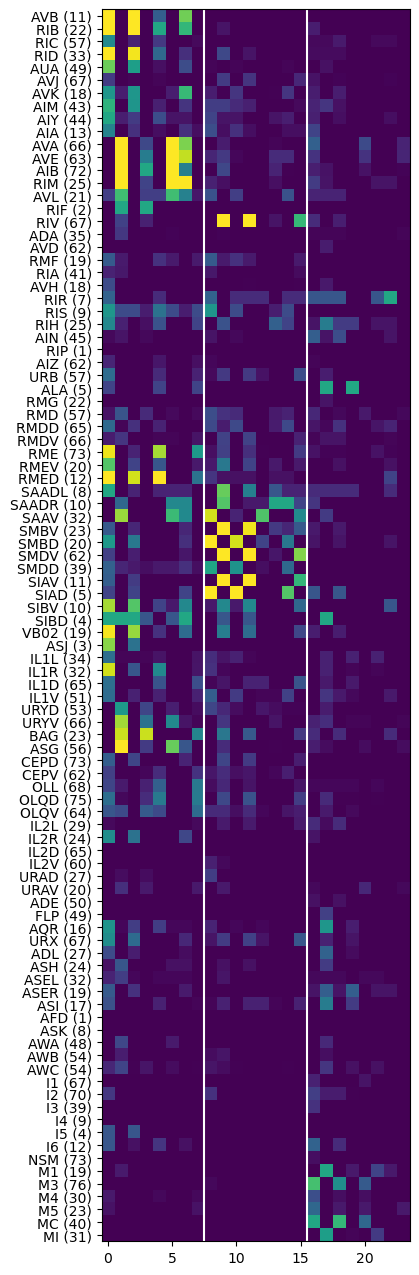

408

In [23]:
let
    list_class_dv = setdiff(list_class_dv_ordered, list_rm_class_dv)
    
    n_class = length(list_class_dv)
    n_behavior_subcat = length(list_b_category)

    array_freq = zeros(n_class, n_behavior_subcat)
    array_n = zeros(n_class)
    dict_n_list = Dict()
    
    for (i_b_c, (b, b_sub, b_sub_label)) = enumerate(list_b_category)
    
        f_count = generate_check_categorization(b, b_sub)
        list_uid_rg_t = b == "P" ? list_uid_use_pumping : list_uid_use_all
        
        dict_frac, dict_n = neuropal_count(list_dict_fit, list_match_dict, list_uid_rg_t, list_class_dv;
            f_count=f_count, f_aggregate_rg_t=any, enc_only=false, merge_rg_t=true)

        for (i_class, class_dv) = enumerate(list_class_dv)
            if haskey(dict_frac, class_dv)
                array_freq[i_class, i_b_c] = dict_frac[class_dv]
            else
                array_freq[i_class, i_b_c] = NaN
            end
            
            if haskey(dict_n, class_dv)
                add_list_dict!(dict_n_list, class_dv, dict_n[class_dv])
            end
        end
    end
    
    for (k,v) = dict_n_list
        count_ = v[1:16]
        count_p_ = v[17:end]
        @assert(all(y->y==count_[1], count_))
        @assert(all(y->y==count_p_[1], count_p_))
    end
    
    list_label = []
    list_label_only = []
    for (i, class_dv) = enumerate(list_class_dv)
        push!(list_label_only, "$class_dv")
        push!(list_label, "$class_dv ($(dict_n_list[class_dv][1]))")
    end
    
    array_img = zeros(size(array_freq)..., 4)
    
    cmap = ColorMap("viridis")
    vmin, vmax = 0.05, 0.8

    for i = 1:size(array_img,1), j = 1:size(array_img,2)
        x_ = array_freq[i,j]
        x_ = rescale_to_range(x_,vmin,vmax)
        array_img[i,j,:] .= cmap(x_)
    end
    
    figure(figsize=(4,16))
    imshow(array_img)
    println("size: $(size(array_img))")
    yticks(0:length(list_label)-1, list_label)
    axvline(7.5, color="white")
    axvline(15.5, color="white")
    
    figure(figsize=(2,12), frameon=false)
    imshow(array_img[:,1:8,:], aspect=1)
    axvline(1.5, color="white", linewidth=0.5)
    axvline(5.5, color="white", linewidth=0.5)
    yticks([])
    xticks([])
    savefig(joinpath(path_fig_root, "neuroapl_table_enc_v.pdf"))
    close()
    
    figure(figsize=(2,12), frameon=false)
    imshow(array_img[:,9:16,:], aspect=1)
    axvline(1.5, color="white", linewidth=0.5)
    axvline(5.5, color="white", linewidth=0.5)
    yticks([])
    xticks([])
    savefig(joinpath(path_fig_root, "neuroapl_table_enc_hc.pdf"))
    close()
    
    figure(figsize=(2,12), frameon=false)
    imshow(array_freq[:,17:24,:], aspect=1)
    axvline(1.5, color="white", linewidth=0.5)
    axvline(5.5, color="white", linewidth=0.5)
    yticks([])
    xticks([])
    savefig(joinpath(path_fig_root, "neuroapl_table_enc_p.pdf"))
    close()
    
    write_txt(joinpath(path_fig_root, "list_label.txt"), mapfoldl(x->x*"\n", *, list_label))
    write_txt(joinpath(path_fig_root, "list_label_only.txt"), mapfoldl(x->x*"\n", *, list_label_only))
end

### Tau

size: (96, 1, 4)


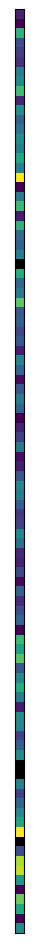

In [24]:
let

    dict_tau, dict_n = neuropal_aggregate_data(list_dict_fit, list_match_dict, list_uid_use_all, list_class_dv_ordered,
        f_aggregate_dataset=median, f_process=get_tau, f_aggregate_rg_t=median, merge_rg_t=true)
        
    list_class_dv = setdiff(list_class_dv_ordered, list_rm_class_dv)

    n_class = length(list_class_dv)
    n_behavior_subcat = length(list_b_category)

    array_feature = zeros(n_class,1)
    for (i_class, class_dv) = enumerate(list_class_dv)
        if haskey(dict_tau, class_dv)
            array_feature[i_class] = dict_tau[class_dv]
        else
            array_feature[i_class] = NaN
        end
    end
    
    vmin = 3
    vmax = 45
        vmin, vmax = log10(vmin), log10(vmax)

    array_img = zeros(size(array_feature)..., 4)
    cmap = ColorMap("viridis")
    for i = 1:length(array_feature)
        x_ = array_feature[i]
        if !isnan(x_)
            x_ = rescale_to_range(log10(x_), vmin, vmax)
            array_img[i,1,:] .= cmap(x_)
        else
            array_img[i,1,:] .= [0.,0.,0.,1.]
        end
    end

    figure(figsize=(2,12), frameon=false)
    imshow(array_img)
    println("size: $(size(array_img))")
    xticks([])
    yticks([])
    savefig(joinpath(path_fig_root, "neuroapl_table_tau.pdf"))
    
end

### Tuning - HB fits

In [25]:
hb_tuning = load("/data1/prj_neuropal/data/hierarchical_tunings_zstd.jld2")["hierarchical_tunings"];

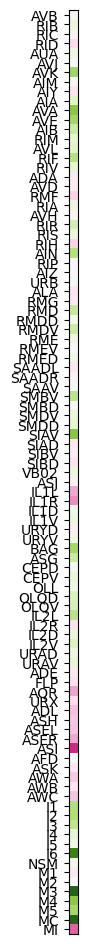

(PyCall.PyObject[PyObject <matplotlib.axis.YTick object at 0x7f7d02df0610>, PyObject <matplotlib.axis.YTick object at 0x7f7d02dd3f70>, PyObject <matplotlib.axis.YTick object at 0x7f7d02dd2830>, PyObject <matplotlib.axis.YTick object at 0x7f7d02df3eb0>, PyObject <matplotlib.axis.YTick object at 0x7f7cde3189a0>, PyObject <matplotlib.axis.YTick object at 0x7f7cde318430>, PyObject <matplotlib.axis.YTick object at 0x7f7cde3198d0>, PyObject <matplotlib.axis.YTick object at 0x7f7cde31a380>, PyObject <matplotlib.axis.YTick object at 0x7f7cde31ae30>, PyObject <matplotlib.axis.YTick object at 0x7f7cde31b8e0>  …  PyObject <matplotlib.axis.YTick object at 0x7f7cddf26200>, PyObject <matplotlib.axis.YTick object at 0x7f7cddf26cb0>, PyObject <matplotlib.axis.YTick object at 0x7f7cddf27760>, PyObject <matplotlib.axis.YTick object at 0x7f7cddf3c250>, PyObject <matplotlib.axis.YTick object at 0x7f7cddf25e40>, PyObject <matplotlib.axis.YTick object at 0x7f7cddf3cac0>, PyObject <matplotlib.axis.YTick obje

In [26]:
let

#     zip(["v_fwd", "θh_dorsal", "P_pos"], ["v","hc","p"], 
        
    tuning_name = "P_pos"
    vmin, vmax = (-0.5,0.5)
        
    array_feature = zeros(length(list_class_dv_ordered),1)
    for (i_class, class_dv) = enumerate(list_class_dv_ordered)
        if haskey(hb_tuning, class_dv)
            array_feature[i_class] = hb_tuning[class_dv][tuning_name]
        end
    end

    array_img = zeros(size(array_feature)..., 4)
    cmap = ColorMap("PiYG")
    for i = 1:length(array_feature)
        x_ = array_feature[i]
        if !isnan(x_)
            x_ = rescale_to_range(x_, vmin, vmax)
            array_img[i,1,:] .= cmap(x_)
        else
            array_img[i,1,:] .= [0.,0.,0.,1.]
        end
    end

    figure(figsize=(2,12), frameon=true)
    imshow(array_img)
    xticks([])
    yticks(0:length(list_class_dv_ordered)-1, list_class_dv_ordered)
end

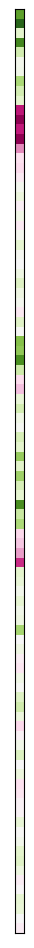

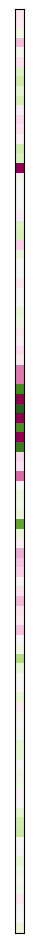

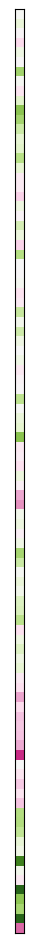

In [27]:
let
    list_class_dv = setdiff(list_class_dv_ordered, list_rm_class_dv)
    
    for (tuning_name, b_name, (vmin, vmax)) = zip(["v_fwd", "θh_dorsal", "P_pos"], ["v","hc","p"], 
            [(-5,5),(-0.5,0.5),(-0.5,0.5)])
        array_feature = zeros(length(list_class_dv),1)
        for (i_class, class_dv) = enumerate(list_class_dv)
            if haskey(hb_tuning, class_dv)
                array_feature[i_class] = hb_tuning[class_dv][tuning_name]
            end
        end

        array_img = zeros(size(array_feature)..., 4)
        cmap = ColorMap("PiYG")
        for i = 1:length(array_feature)
            x_ = array_feature[i]
            if !isnan(x_)
                x_ = rescale_to_range(x_, vmin, vmax)
                array_img[i,1,:] .= cmap(x_)
            else
                array_img[i,1,:] .= [0.,0.,0.,1.]
            end
        end

        figure(figsize=(2,12), frameon=false)
        imshow(array_img)
        xticks([])
        yticks([])
        savefig(joinpath(path_fig_root, "neuroapl_table_tuning_$(b_name).pdf"))
    end
end

### Tuning - tuning strength extra

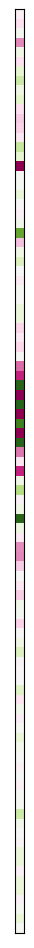

(Any[], Any[])

In [28]:
let
    function generate_get_tuning(k="v_fwd")
        function get_tuning_(dict_fit, categorization, idx_neuron, i_rg_t)
            dict_tuning = dict_fit["tuning_strength"]["$i_rg_t"]["$idx_neuron"]
            dict_tuning[k]
        end
        
        return get_tuning_
    end
# θh_dorsal
    f_tuning = generate_get_tuning("θh_dorsal")
    dict_feature, dict_n = neuropal_aggregate_data(list_dict_fit, list_match_dict, list_uid_use_all, list_class_dv_ordered,
        f_process=f_tuning, f_aggregate_dataset=mean, f_aggregate_rg_t=mean,
        merge_rg_t=true, enc_only=false)
    
    n_class = length(list_class_dv_ordered)
    n_behavior_subcat = length(list_b_category)

    array_feature = zeros(n_class,1)
    for (i_class, class_dv) = enumerate(list_class_dv_ordered)
        if haskey(dict_feature, class_dv)
            array_feature[i_class] = dict_feature[class_dv]
        else
            array_feature[i_class] = NaN
        end
    end
    
    vmin = -0.25
    vmax = 0.25
    array_img = zeros(size(array_feature)..., 4)
    cmap = ColorMap("PiYG")
    for i = 1:length(array_feature)
        x_ = array_feature[i]
        if !isnan(x_)
            x_ = rescale_to_range(x_, vmin, vmax)
            array_img[i,1,:] .= cmap(x_)
        else
            array_img[i,1,:] .= [0.,0.,0.,1.]
        end
    end

    figure(figsize=(2,12), frameon=false)
    imshow(array_img)
    xticks([])
    yticks([])

end

### Relative encoding strength

In [29]:
hb_model_rel_enc = load("/data1/prj_neuropal/data/hierarchical_relative_encoding_strength.jld2")["hierarchical_relative_encoding_strength"];

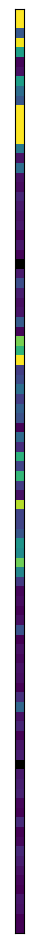

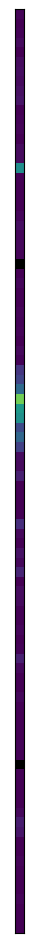

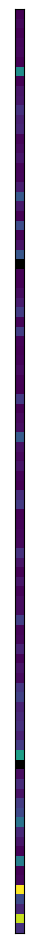

In [30]:
let
    list_class_dv = setdiff(list_class_dv_ordered, list_rm_class_dv)

    dict_feature = Dict()
    for (k,v) = hb_model_rel_enc
        enc_strength =  v["var"]
        dict_feature[k] = collect(enc_strength .* [v["v"], v["θh"], v["P"]])
    end
    
    for i_b = 1:3
        n_class = length(list_class_dv)    
        array_feature = zeros(n_class,1)
        for (i_class, class_dv) = enumerate(list_class_dv)
            if haskey(dict_feature, class_dv)
                array_feature[i_class] = dict_feature[class_dv][i_b]
            else
                array_feature[i_class] = NaN
            end
        end

        array_feature .= abs.(array_feature)

        vmin = 0
        vmax = 0.5

        array_img = zeros(size(array_feature)..., 4)
        cmap = ColorMap("viridis")
        for i = 1:length(array_feature)
            x_ = array_feature[i]
            if !isnan(x_)
                x_ = rescale_to_range(x_, vmin, vmax)
                array_img[i,1,:] .= cmap(x_)
            else
                array_img[i,1,:] .= [0.,0.,0.,1.]
            end
        end

        figure(figsize=(2,12), frameon=false)
        imshow(array_img)
        xticks([])
        yticks([])
        savefig(joinpath(path_fig_root, "neuroapl_table_enc_strength_$(i_b).pdf"))
    end
end

### Signal

In [31]:
neuropal_signal = load("/data1/prj_neuropal/data/neuropal_signal.jld2")["neuropal_signal"];

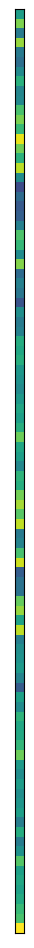

In [32]:
let
    list_class_dv = setdiff(list_class_dv_ordered, list_rm_class_dv)

    dict_feature = Dict()
    for (k,v) = neuropal_signal
        signals = neuropal_signal[k]
        if length(signals) > 1
            dict_feature[k] = mean(signals)
        else
            dict_feature[k] = signals[1]
        end
    end
    

    n_class = length(list_class_dv)    
    array_feature = zeros(n_class,1)
    for (i_class, class_dv) = enumerate(list_class_dv)
        if haskey(dict_feature, class_dv)
            array_feature[i_class] = dict_feature[class_dv]
        else
            array_feature[i_class] = NaN
        end
    end

    vmin = 0
    vmax = 0.5

    array_img = zeros(size(array_feature)..., 4)
    cmap = ColorMap("viridis")
    for i = 1:length(array_feature)
        x_ = array_feature[i]
        if !isnan(x_)
            x_ = rescale_to_range(x_, vmin, vmax)
            array_img[i,1,:] .= cmap(x_)
        else
            array_img[i,1,:] .= [0.,0.,0.,1.]
        end
    end

    figure(figsize=(2,12), frameon=false)
    imshow(array_img)
    xticks([])
    yticks([])
    savefig(joinpath(path_fig_root, "neuroapl_table_signal.pdf"))
end

### Variability

In [33]:
extrapolated_behaviors = load("/data1/prj_neuropal/data/extrapolated_behaviors.jld2")["extrapolated_behaviors"];
eb_n_t = size(extrapolated_behaviors,1)
eb_list_b = [extrapolated_behaviors[:,i] for i = 1:3];
hb_model_result = load("/data1/prj_neuropal/data/hierarchical_dict.jld2")["hierarchical_dict"]
hb_model_rel_enc = load("/data1/prj_neuropal/data/hierarchical_relative_encoding_strength.jld2")["hierarchical_relative_encoding_strength"];

┌ Warning: type HierarchicalPosteriorModel.HBParams does not exist in workspace; reconstructing
└ @ JLD2 ~/.julia/packages/JLD2/ryhNR/src/data/reconstructing_datatypes.jl:495


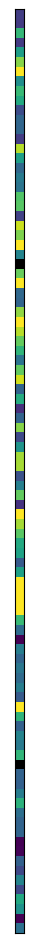

In [34]:
let
    list_class_dv = setdiff(list_class_dv_ordered, list_rm_class_dv)

    dict_feature = Dict()
    for (k,v) = hb_model_result["variability"]
        dict_feature[k] = v
    end
    

    n_class = length(list_class_dv)    
    array_feature = zeros(n_class,1)
    for (i_class, class_dv) = enumerate(list_class_dv)
        if haskey(dict_feature, class_dv)
            array_feature[i_class] = dict_feature[class_dv]
        else
            array_feature[i_class] = NaN
        end
    end

    vmin = 0
    vmax = 2.

    array_img = zeros(size(array_feature)..., 4)
    cmap = ColorMap("viridis")
    for i = 1:length(array_feature)
        x_ = array_feature[i]
        if !isnan(x_)
            x_ = rescale_to_range(x_, vmin, vmax)
            array_img[i,1,:] .= cmap(x_)
        else
            array_img[i,1,:] .= [0.,0.,0.,1.]
        end
    end

    figure(figsize=(2,12), frameon=false)
    imshow(array_img)
    xticks([])
    yticks([])
    savefig(joinpath(path_fig_root, "neuroapl_table_var.pdf"))
end

In [35]:
["OLQ","OLL","RIH","IL1","URX","URB"]

6-element Vector{String}:
 "OLQ"
 "OLL"
 "RIH"
 "IL1"
 "URX"
 "URB"

In [36]:
["OLQ","OLL","IL1","RIH","CEP","URX"]

6-element Vector{String}:
 "OLQ"
 "OLL"
 "IL1"
 "RIH"
 "CEP"
 "URX"

In [37]:
sort([(k,v) for (k,v) = hb_model_result["variability"]], by=x->x[2],rev=true)

94-element Vector{Tuple{String, Float64}}:
 ("OLQD", 2.59490079912999)
 ("OLQV", 2.5806751680948374)
 ("OLL", 2.515560676613954)
 ("AVK", 2.194714612434139)
 ("IL1D", 2.0696851386737416)
 ("RIH", 2.055419835178538)
 ("CEPV", 2.0313502334904943)
 ("RMDD", 2.019824125617851)
 ("URX", 2.003571425133294)
 ("URB", 1.9928353411877677)
 ("SAADR", 1.861131764438713)
 ("RIR", 1.8423550249481484)
 ("RMDV", 1.786909436168866)
 ⋮
 ("NSM", 0.4312198472965438)
 ("AVH", 0.38338095749953444)
 ("AVB", 0.3617290465561651)
 ("RIM", 0.35707220689570995)
 ("RID", 0.3492863761314783)
 ("RIB", 0.34623073349806044)
 ("IL1R", 0.2898826144862093)
 ("SMBD", 0.27786468632488126)
 ("I5", 0.01965295650256247)
 ("I4", 0.0030247759849645773)
 ("MC", 0.00023689572536890048)
 ("IL2D", 0.00022343344515610855)